### 1. Pobranie zbioru cifar i wyświetlenie kilku obrazów

Files already downloaded and verified


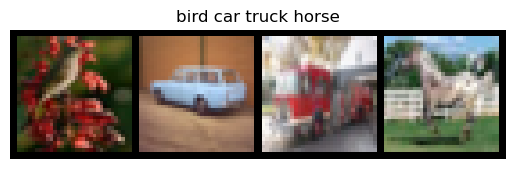

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

showloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

def imshow(img, labels):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    label_text = ' '.join(classes[labels[j]] for j in range(len(labels)))
    plt.title(label_text)
    plt.axis('off')
    plt.show()

dataiter = iter(showloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), labels)

### 3. Stworzenie sieci neuronowej podobnej do LeNet-5

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5CIFAR10(nn.Module):
    def __init__(self):
        super(LeNet5CIFAR10, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Layer 1: Convolution -> ReLU -> Avg Pooling
        x = F.relu(self.conv1(x))          # Conv1
        x = F.avg_pool2d(x, 2)             # 2x2 Avg Pooling
        
        # Layer 2: Convolution -> ReLU -> Avg Pooling
        x = F.relu(self.conv2(x))          # Conv2
        x = F.avg_pool2d(x, 2)             # 2x2 Avg Pooling
        
        # Flatten the output for fully connected layers
        x = x.view(-1, 16 * 5 * 5)
        
        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output layer (before softmax)
        x = self.fc3(x)
        
        # Apply softmax for class probabilities
        return F.softmax(x, dim=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LeNet5CIFAR10().to(device)

print(net)

params = 0
for parameter in net.parameters(): 
    subsum=1
    for el in parameter.size():
        subsum*=el
    params+=subsum
    
print(params)



LeNet5CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
62006


### 6-10. Zapętlenie w treningu

In [23]:
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
from datetime import datetime, timedelta


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Podział danych treningowych na zbiór treningowy i walidacyjny (90% na trening, 10% na walidację)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Stworzenie DataLoaderów
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.002) # learning rate w miarę dobry dla Adama

# Pętla treningowa
num_epochs = 10
start_time = datetime.now()
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Resetowanie gradientów
        optimizer.zero_grad()
        
        # Przepuszczenie danych przez sieć, obliczenie funkcji kosztu i wstecznej propagacji
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    # Obliczenie validation loss
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Elapsed time: {datetime.now() - start_time}")

# Testowanie modelu - obliczenie accuracy
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Training Loss: 2.1599, Validation Loss: 2.1094, Elapsed time: 0:01:03.735386
Epoch 2/10, Training Loss: 2.0876, Validation Loss: 2.0618, Elapsed time: 0:01:36.780064
Epoch 3/10, Training Loss: 2.0553, Validation Loss: 2.0585, Elapsed time: 0:02:08.809854
Epoch 4/10, Training Loss: 2.0425, Validation Loss: 2.0649, Elapsed time: 0:02:39.885934
Epoch 5/10, Training Loss: 2.0284, Validation Loss: 2.0167, Elapsed time: 0:03:13.197674
Epoch 6/10, Training Loss: 2.0238, Validation Loss: 2.0410, Elapsed time: 0:03:44.163056
Epoch 7/10, Training Loss: 2.0125, Validation Loss: 2.0136, Elapsed time: 0:04:17.162842
Epoch 8/10, Training Loss: 2.0056, Validation Loss: 2.0191, Elapsed time: 0:04:50.307064
Epoch 9/10, Training Loss: 2.0051, Validation Loss: 2.0240, Elapsed time: 0:05:24.624843
Epoch 10/10, Training Loss: 1.9940, Validation Loss: 1.9915, Elapsed time: 0:05:58.220890
Test Accuracy: 45.56%
